Author: Lukas Mosser  
Year: 2019  
License: MIT

In [1]:
%pylab inline
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torchvision import transforms

from snist import SNIST

from utils import set_seed, transform
from utils import count_parameters, plot_amplitudes_grid, plot_velocity_profiles_grid, plot_losses
from utils import store_model_checkpoint, load_model_checkpoint, plot_wiggle_traces

device = 'cpu'
cuda = False
if torch.cuda.is_available():
    device = 'cuda'
    print("Running on GPU")
    cuda = True

Populating the interactive namespace from numpy and matplotlib
Running on GPU


# Seismic-NIST Reference Benchmark Implementation

This is a reference implementation for the SNIST dataset.  
The model is based off of Roeth and Tarantola's work around velocity inversion from seismic amplitude data.  

We use a single-hidden layer neural network with 5421 inputs, 25 neurons and 9 outputs.
The network is trained with full batch gradient descent as per the original publication.

We report average mean-squared-error in meters per second for three test sets:
- Noise 0: No added noise on the velocities
- Noise 1: 1 sigma of noise has been added to the amplitudes
- Noise 2: 2 sigma of noise have been added to the amplitudes


## Setting the hyperparameters for learning and loading of the data

In [2]:
N_train = 600 #Number of total training examples
N_val = 150 #Number of samples used for validation
N_samples = 271 #Number of samples in time
N_recorders = 20 #Number of recording stations
N_layers = 9 #Number of layers in the target velocity model
N_z = 360 #Number of grid blocks in z-dimension (only used for visualisation)
lr = 1e-2 #Learning rate
batch_size = N_train-N_val #Batchsize used in training - do full batch evaluation because of small data
N_epochs = 200 #Number of epochs to train for

## Loading amplitude, interval velocity data

In [3]:
#Setting up the training dataset
train_dataset = SNIST('./', train=True, download=True)
train_dataset.data = train_dataset.data[0:-N_val]
train_dataset.targets = train_dataset.targets[0:-N_val]

#Splitting out the validation set
validation_dataset =  SNIST('./', train=True, download=True)
validation_dataset.data  = validation_dataset.data[-N_val:]
validation_dataset.targets = validation_dataset.targets[-N_val:]

#Obtaining the normalisation constants
train_mean, train_std, velo_max = train_dataset.data.mean(), train_dataset.data.std(), train_dataset.targets.max()

#Normalising the velocities
train_dataset.targets /= velo_max
validation_dataset.targets /= velo_max

#Setting up the training and validation Dataloader objects
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=N_val, shuffle=False)

#Obtaining the test sets
#Test Set 0 - No noise
#Test Set 1 - 1 sigma of noise
#Test Set 2 - 2 sigma of noise
test_dataset_noise_0 = SNIST('./', train=False, noise=0)
test_dataset_noise_1 = SNIST('./', train=False, noise=1)
test_dataset_noise_2 = SNIST('./', train=False, noise=2)

#Again, normalising the targets
test_dataset_noise_0.targets /= velo_max
test_dataset_noise_1.targets /= velo_max
test_dataset_noise_2.targets /= velo_max

#Setting up the test loaders
test_loader_noise_0 = DataLoader(test_dataset_noise_0, batch_size=len(test_dataset_noise_0.data), shuffle=False)
test_loader_noise_1 = DataLoader(test_dataset_noise_1, batch_size=len(test_dataset_noise_1.data), shuffle=False)
test_loader_noise_2 = DataLoader(test_dataset_noise_2, batch_size=len(test_dataset_noise_2.data), shuffle=False)

Processing...
Done!


## Inspecting the training data

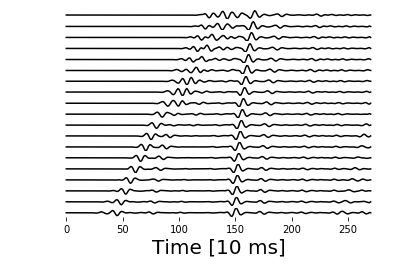

In [ ]:
example = train_dataset[0][0].view(N_samples, N_recorders).numpy()
fig = plt.figure()
plot_wiggle_traces(fig, example, N_recorders)

## Defining the model, training and validation loop

In [ ]:
#Set the random number generator
set_seed(42)

#Weight Initialisation
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.00)

#Setup our model - simple neural network based on Roeth and Tarantola 1994
model = nn.Sequential(*[nn.Linear(N_samples*N_recorders, 25), nn.Sigmoid(), nn.Linear(25, N_layers), nn.Sigmoid()]).to(device)
model.apply(init_weights)
print("Total number of model parameters: ", count_parameters(model))

#Setup the SGD optimizer and learning rate stepper - momentum = 0 because they didn't use it at the time
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
stepper = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5, min_lr=1e-5)

#Criterion will be the Mean-Squared-Error
criterion = nn.MSELoss(reduction="sum")

#Dummy variables to store intermediate results
losses = []
lowest_loss = np.inf
for epoch in range(N_epochs):
    model.train()
    train_loss = 0.0
    for X, y in train_loader: #Iterate over the training data
        optimizer.zero_grad() #Set our gradients to zero
        
        #Perform Normalisation
        X -= train_mean
        X /= train_std
        X = X.view(-1, X.size(2)*X.size(3))
        
        #Forward propagate the input data
        y_ = model(X.to(device))
        
        #Compute the loss
        loss = criterion(y_.to(device), y.to(device))
        
        #Backpropagate the loss
        loss.backward()
        
        #Make a small step to optimize
        optimizer.step()
        train_loss += loss.item() #Accumulate total training loss
        
    #Set model to evaluation mode
    model.eval()
    validation_loss = 0.0
    with torch.set_grad_enabled(False): #No need for gradients here
        for X, y in validation_loader: #Iterate over the validation set
            #Perform Normalisation
            X -= train_mean
            X /= train_std
            X = X.view(-1, X.size(2)*X.size(3))

             #Forward propagate the input data
            y_ = model(X.to(device))
            
            #Compute the loss
            loss = criterion(y_.to(device), y.to(device))
            validation_loss += loss.item()#Accumulate total validation loss
                
                
    #Compute the average losses per example in m/s (velocities)
    train_loss *= velo_max/len(train_loader.dataset)
    validation_loss *= velo_max/len(validation_loader.dataset)
    
    #Reduce learning rate if necessary
    stepper.step(validation_loss)
    
    #Get current learning rate - for output only
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    
    #Store best model if validation loss improved
    if lowest_loss > validation_loss:
        store_model_checkpoint("./best_model.pth", epoch, model, optimizer, validation_loss)
        lowest_loss = validation_loss

    #Append losses - for output only
    losses.append([train_loss, validation_loss])
    
    #Print output every 10 epochs
    if epoch % 10 == 9:
        print("Current Epoch: ", epoch, "Training Loss: %.3f" % train_loss, "[m/s], Validation Loss: %.3f" % validation_loss, "[m/s], Learning rate: %.6f"%lr)

## Plotting the training and test loss 

In [ ]:
losses_np = np.array(losses)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_losses(ax, losses_np)
plt.legend(fontsize=24)

 Leaves lots of room for improvement! :)

## Load the best model checkpoint

In [ ]:
model, _, epoch, loss = load_model_checkpoint("./best_model.pth", model, optimizer)
print("Best model is from epoch: ", epoch, " and had a loss of %.4f" % loss)

## Defining a helper function for model evaluation incl. adding noise

In [ ]:
def test(test_loader, model, mean, std, vmax, device='cpu'):
    model.eval()
    criterion = nn.MSELoss(reduction='sum')
    with torch.set_grad_enabled(False):
        for X, y in test_loader:
            X -= mean
            X /= std
            X = X.view(-1, X.size(2)*X.size(3))
            y_ = model(X.to(device))
            loss = criterion(y_.to(device), y.to(device))
    
    reported_loss = loss*vmax/len(test_loader.dataset)
    print("The average loss on the test set is %3.3f" %reported_loss.item(), " [m/s]")
    return X.to('cpu'), y.to('cpu'), y_.to('cpu'), reported_loss

## Evaluating the model on test set (no noise)

In [ ]:
example = test_loader_noise_0.dataset[0][0].view(N_samples, N_recorders).numpy()
fig = plt.figure()
plot_wiggle_traces(fig, example, N_recorders)

In [ ]:
X, y, y_, test_loss_noise_0 = test(test_loader_noise_0, model, train_mean, train_std, velo_max, device=device)
ax = plot_amplitudes_grid(X, N_samples, N_recorders)

In [ ]:
ax = plot_velocity_profiles_grid(y, y_, N_z)

## Evaluating the model on test set ($1 \ \sigma$ noise)

In [ ]:
example = test_loader_noise_1.dataset[0][0].view(N_samples, N_recorders).numpy()
fig = plt.figure()
plot_wiggle_traces(fig, example, N_recorders)

In [ ]:
X, y, y_, test_loss_noise_1 = test(test_loader_noise_1, model, train_mean, train_std, velo_max, device=device)
ax = plot_amplitudes_grid(X, N_samples, N_recorders)

In [ ]:
ax = plot_velocity_profiles_grid(y, y_, N_z)

## Evaluating the model on test set ($2 \ \sigma$ noise)

In [ ]:
example = test_loader_noise_2.dataset[0][0].view(N_samples, N_recorders).numpy()
fig = plt.figure()
plot_wiggle_traces(fig, example, N_recorders)

In [ ]:
X, y, y_, test_loss_noise_2 = test(test_loader_noise_2, model, train_mean, train_std, velo_max, device=device)
ax = plot_amplitudes_grid(X, N_samples, N_recorders)

In [ ]:
ax = plot_velocity_profiles_grid(y, y_, N_z)

In [ ]:
print("Summary of the model performance on the test set: ")
print("Test Set 0 Loss: %3.3f" %test_loss_noise_0.item(), " [m/s]")
print("Test Set 1 Loss: %3.3f" % test_loss_noise_1.item(), " [m/s]")
print("Test Set 2 Loss: %3.3f" % test_loss_noise_2.item(), " [m/s]")